In [1]:
from tabpfn import TabPFNClassifier
from sklearn.ensemble import RandomForestClassifier

import experiments.runners as runners
from data import load_us_perm_visas, load_credit_default

rf_model = RandomForestClassifier()
pfn_model = TabPFNClassifier()

In [2]:
X, y = load_credit_default()

In [3]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
import math
from models.preprocessors import DatetimeFeatureSplitter, DatetimeFeatureEncoder


In [5]:
## RF Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('datetime', DatetimeFeatureEncoder(), make_column_selector(dtype_include='datetime64[ns]')),
        ('cat high c', TargetEncoder(), make_column_selector(dtype_include='object')),
        ('num',SimpleImputer(strategy='constant', fill_value=0), make_column_selector(dtype_include=['int64', 'float64'])), # no need to scale numerical columns for RandomForest
        ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include='category'))
        # ('pass', 'passthrough', make_column_selector(dtype_exclude=['datetime64']))
    ],
    remainder='passthrough'
    )        

# Create classifier pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', pfn_model)
])

In [ ]:
## TabPFN pipeline
preprocessor = ColumnTransformer(
    transformers=[
            ('datetime', DatetimeFeatureSplitter(), make_column_selector(dtype_include='datetime64[ns]')),
            ('num', SimpleImputer(strategy='mean'), make_column_selector(dtype_include=['int64', 'float64'])), # Here we see the limit of the approach: different strategy between models
            ('cat', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include='category')),
            ('cat high cardinality', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include='object')),
            # todo: this isn't great, having to impute values for TabPFN. But the model otherwise had issues with missing variables. 
            # I think TabPFN expects missing values to be formatted in a certain way. Here it got an NA type or so in what it expected to be a str column

        ],
    remainder='passthrough'
    )        

# Create classifier pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', pfn_model)
])

In [6]:
max_size_for_model = 30000
n_splits = 5

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, StratifiedKFold # Use StratifiedKFold for classification
# Assuming you have:
# pfn_model: Your instantiated TabPFN model
# X, y: Your full dataset for a particular task

# Define cross-validation strategy (e.g., 5-fold stratified)
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

n_samples = len(X)
n_splits = cv.get_n_splits(X, y) # Get n_splits from the cv object

# Calculate max size allowed by the CV split
max_size_from_cv = int(n_samples * (1 - 1 / n_splits))

# Determine the final max size, considering both CV and model limits
final_max_train_size = min(max_size_for_model, max_size_from_cv)

# Define train_sizes, ensuring it doesn't exceed the final_max_train_size
# Example: 10 steps from 100 up to the calculated maximum
start_size = 100
num_steps = 10

if final_max_train_size < start_size:
    # Handle cases where even the smallest desired size is too large
    # Maybe just use one size? Or raise an error?
    train_sizes_abs = np.array([final_max_train_size])
    print(f"Warning: Max allowed train size ({final_max_train_size}) is less than start_size ({start_size}). Using only max size.")
else:
    train_sizes_abs = np.linspace(start_size, final_max_train_size, num_steps, dtype=int)

print(f"Total samples: {n_samples}")
print(f"CV folds: {n_splits}")
print(f"Max training samples per fold: {max_size_from_cv}")
print(f"Model/Config limit: {max_size_for_model}")
print(f"Final max train size used in learning curve: {final_max_train_size}")
print(f"Train sizes to be tested: {train_sizes_abs}")

Total samples: 30000
CV folds: 5
Max training samples per fold: 24000
Model/Config limit: 30000
Final max train size used in learning curve: 24000
Train sizes to be tested: [  100  2755  5411  8066 10722 13377 16033 18688 21344 24000]


Generating learning curve for RF...


/opt/homebrew/Caskroom/miniforge/base/envs/tabpfn/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tabpfn/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tabpfn/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tabpfn/lib/python3.13/site-packages/skl

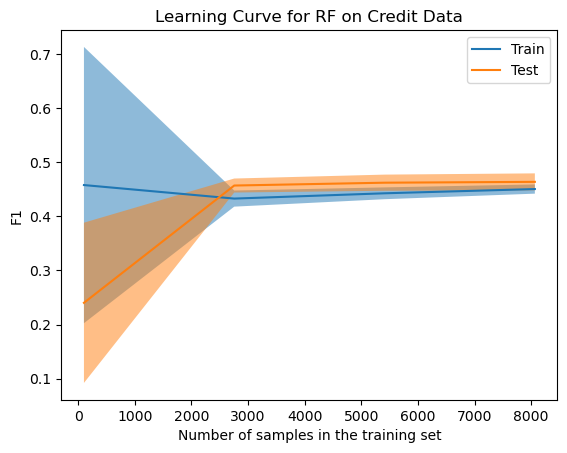

In [8]:
print(f"Generating learning curve for RF...")
# Use LearningCurveDisplay.from_estimator
display = LearningCurveDisplay.from_estimator(
    pipeline,
    X,
    y,
    cv=cv,
    train_sizes=train_sizes_abs, # Use absolute sizes suitable for TabPFN
    scoring="f1",  # Or "roc_auc", "f1", "neg_log_loss", etc. depending on your goal
    n_jobs=3,  # Number of CPU cores to use
    random_state=42, # Consistent state for any internal randomness if needed
    # Add other relevant parameters if needed
)

display.ax_.set_title(f"Learning Curve for RF on Credit Data")
plt.show()